## Importing the required packages

In [1]:
# Standard library imports
import os
import shutil
import random

# Data handling
import numpy as np
import pandas as pd

# Machine Learning and Neural Network libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Add, MaxPooling2D, Dense, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 

# SciPy and Sklearn for additional functionalities
import scipy as sp
from scipy import ndimage
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
# File Paths for Dataset
dog_file_path = "C:/Users/YASHWANTH/Downloads/archive (2)/PetImages/Dog"
cat_file_path = "C:/Users/YASHWANTH/Downloads/archive (2)/PetImages/Cat"

In [3]:
import plotly.express as px

class_names = ['Cat', 'Dog']
n_dogs = len(os.listdir(dog_file_path))
n_cats = len(os.listdir(cat_file_path))
n_images = [n_cats, n_dogs]

fig = px.pie(names=class_names, values=n_images, title='Dataset Class Distribution', 
             color=class_names, 
             color_discrete_map={'Cat':'lightcyan', 'Dog':'lightgoldenrodyellow'})

fig.update_traces(textinfo='percent+label+value', pull=[0.1, 0])
fig.show()


In [ ]:
## 1 Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

In [4]:
import os
import random

def split_data_fixed_sizes(main_dir, train_size=1000, val_size=500):
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)):  # check if the file's size isn't 0
            files.append(file)  # appends file name to a list

    shuffled_files = random.sample(files, len(files))  # shuffles the data

    # Assign files to train, validation, and test sets based on specified sizes
    train_files = shuffled_files[:train_size]
    validation_files = shuffled_files[train_size:train_size+val_size]
    test_files = shuffled_files[train_size+val_size:train_size+val_size+500]  # Assuming the remainder are test files

    return train_files, validation_files, test_files

# Split the data for cats and dogs
train_cats, val_cats, test_cats = split_data_fixed_sizes(cat_file_path)
train_dogs, val_dogs, test_dogs = split_data_fixed_sizes(dog_file_path)

print("Cats - Training:", len(train_cats), "Validation:", len(val_cats), "Test:", len(test_cats))
print("Dogs - Training:", len(train_dogs), "Validation:", len(val_dogs), "Test:", len(test_dogs))

Cats - Training: 1000 Validation: 500 Test: 500
Dogs - Training: 1000 Validation: 500 Test: 500


In [5]:
# Function to create a dataframe from file names and labels
def create_dataframe(file_names, label, main_dir):
    return pd.DataFrame({
        'filename': [os.path.join(main_dir, fname) for fname in file_names],
        'class': label
    })

# Create dataframes
train_df = pd.concat([create_dataframe(train_cats, 'cat', cat_file_path), create_dataframe(train_dogs, 'dog', dog_file_path)])
val_df = pd.concat([create_dataframe(val_cats, 'cat', cat_file_path), create_dataframe(val_dogs, 'dog', dog_file_path)])
test_df = pd.concat([create_dataframe(test_cats, 'cat', cat_file_path), create_dataframe(test_dogs, 'dog', dog_file_path)])

# Shuffle the dataframes
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [6]:
# Image Data Generators
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen =  ImageDataGenerator(rescale=1./255.)
test_gen =  ImageDataGenerator(rescale=1./255.)


# Data Generators from Dataframes
train_generator = train_gen.flow_from_dataframe(dataframe=train_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')
validation_generator = validation_gen.flow_from_dataframe(dataframe=val_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')
test_generator = test_gen.flow_from_dataframe(dataframe=test_df, x_col='filename', y_col='class', target_size=(150, 150), batch_size=64, class_mode='binary')


Found 2000 validated image filenames belonging to 2 classes.
Found 999 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


C:\Users\YASHWANTH\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning:

Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.



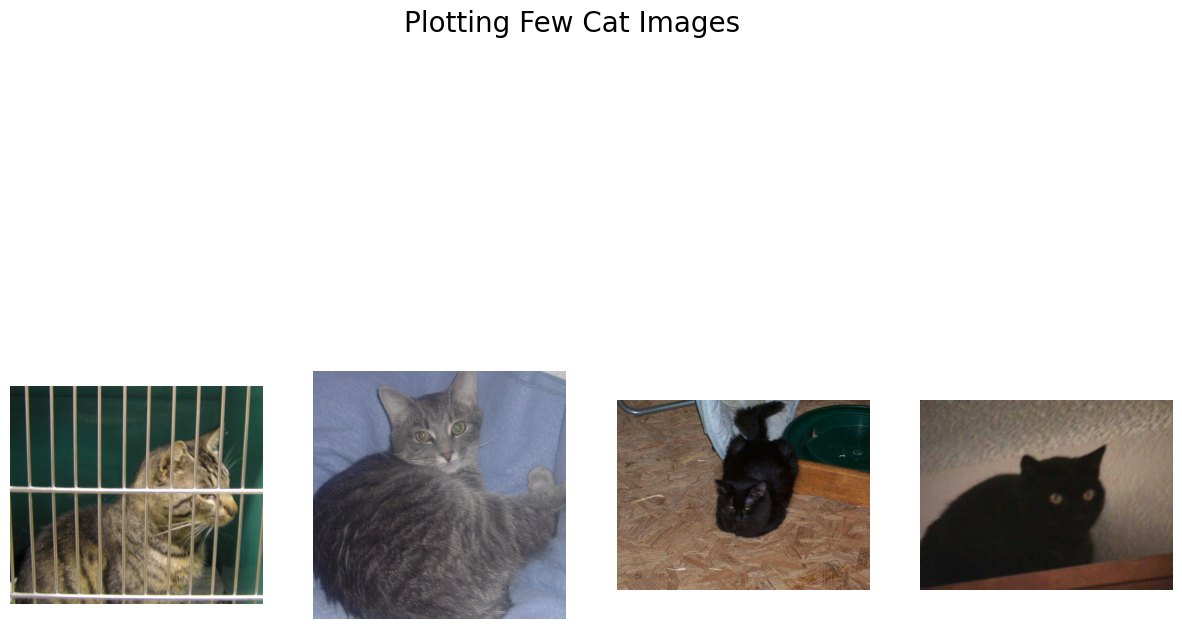

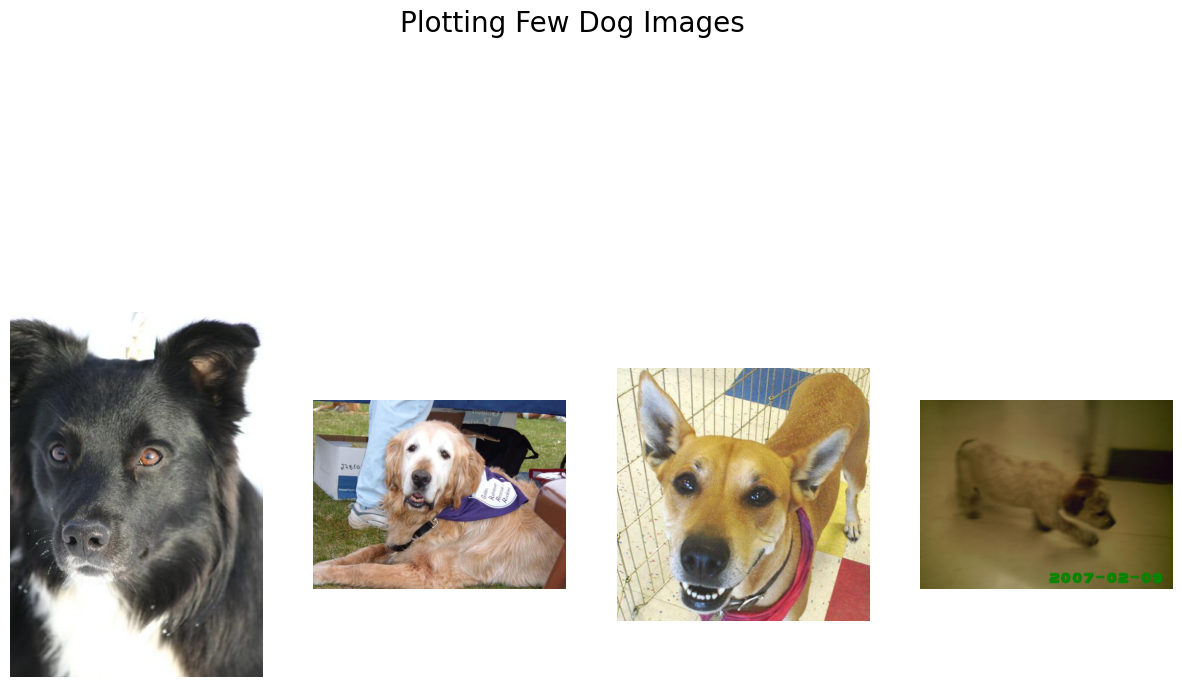

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def plot_images_from_directory(file_paths, directory_path, title, num_images=4):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 10))
    fig.suptitle(title, fontsize=20)
    for i, file_path in enumerate(file_paths[:num_images]):
        img_path = os.path.join(directory_path, file_path)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Assuming `train_cats` and `train_dogs` contain the file names of the images
cat_images_to_plot = train_cats[:4]  # Select the first 4 cat images
dog_images_to_plot = train_dogs[:4]  # Select the first 4 dog images

# Replace 'cat_file_path' and 'dog_file_path' with the actual directories containing the images
plot_images_from_directory(cat_images_to_plot, cat_file_path, 'Plotting Few Cat Images')
plot_images_from_directory(dog_images_to_plot, dog_file_path, 'Plotting Few Dog Images')


In [8]:
# Building the CNN model
inputs = tf.keras.layers.Input(shape=(150,150,3))
# Convolutional layer with 32 filters of size 3x3, using ReLU activation function
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
# Another Convolutional layer with increased filters for capturing more complex features
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# MaxPooling to reduce dimensionality and prevent overfitting
x = tf.keras.layers.MaxPooling2D(2,2)(x)

# Additional Convolutional layers with increasing filter size for deeper feature extraction
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)

# Global Average Pooling layer for reducing overfitting and improving model efficiency
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers for classification
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x) 

model = Model(inputs=inputs, outputs=x)

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 30, 30, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 838,146 (3.20 MB)

 Trainable params: 838,146 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Model Compilation
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Model Training with ModelCheckpoint Callback
checkpoint_filepath = "epoch_at_{epoch:02d}.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1
)


In [11]:
# Model Training
r = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[model_checkpoint_callback]  # Add the callback here
)

Epoch 1/10


C:\Users\YASHWANTH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5038 - loss: 0.6942
Epoch 1: saving model to epoch_at_01.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.5038 - loss: 0.6942 - val_accuracy: 0.5005 - val_loss: 0.6933
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5031 - loss: 0.6935
Epoch 2: saving model to epoch_at_02.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.5031 - loss: 0.6935 - val_accuracy: 0.5005 - val_loss: 0.6931
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5210 - loss: 0.6928
Epoch 3: saving model to epoch_at_03.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.5207 - loss: 0.6928 - val_accuracy: 0.4995 - val_loss: 0.6921
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4970 - loss: 0.6931
Epoch 4: saving model to epoch_at_04.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.4969 - loss: 0.6931 - val_accuracy: 0.5606 - val_loss: 0.6913
Epoch 5/10
32/32 ━━━━━━━━━

# 2 Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve? 

In [12]:
import os
import random

def split_data_fixed_sizes(main_dir, train_size=5000, val_size=500):
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)):  # check if the file's size isn't 0
            files.append(file)  # appends file name to a list

    shuffled_files = random.sample(files, len(files))  # shuffles the data

    # Assign files to train, validation, and test sets based on specified sizes
    train_files = shuffled_files[:train_size]
    validation_files = shuffled_files[train_size:train_size+val_size]
    test_files = shuffled_files[train_size+val_size:train_size+val_size+500]  # Assuming the remainder are test files

    return train_files, validation_files, test_files

# Split the data for cats and dogs with updated sizes
train_cats_2, val_cats_2, test_cats_2 = split_data_fixed_sizes(cat_file_path, train_size=5000, val_size=500)
train_dogs_2, val_dogs_2, test_dogs_2 = split_data_fixed_sizes(dog_file_path, train_size=5000, val_size=500)

print("Cats - Training:", len(train_cats_2), "Validation:", len(val_cats_2), "Test:", len(test_cats_2))
print("Dogs - Training:", len(train_dogs_2), "Validation:", len(val_dogs_2), "Test:", len(test_dogs_2))

Cats - Training: 5000 Validation: 500 Test: 500
Dogs - Training: 5000 Validation: 500 Test: 500


In [13]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming you've already executed the split_data_fixed_sizes function with the updated sizes
# And you've updated your file paths 'cat_file_path' and 'dog_file_path'

# Use the updated lists for creating dataframes
train_df_2 = pd.concat([
    create_dataframe(train_cats_2, 'cat', cat_file_path), 
    create_dataframe(train_dogs_2, 'dog', dog_file_path)
])

val_df_2 = pd.concat([
    create_dataframe(val_cats_2, 'cat', cat_file_path), 
    create_dataframe(val_dogs_2, 'dog', dog_file_path)
])

test_df_2 = pd.concat([
    create_dataframe(test_cats_2, 'cat', cat_file_path), 
    create_dataframe(test_dogs_2, 'dog', dog_file_path)
])

# Shuffle the dataframes
train_df_2 = train_df_2.sample(frac=1).reset_index(drop=True)
val_df_2 = val_df_2.sample(frac=1).reset_index(drop=True)
test_df_2 = test_df_2.sample(frac=1).reset_index(drop=True)

# Assuming the ImageDataGenerator instantiation stays the same
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# Creating the data generators from the new dataframes
train_generator_2 = train_gen.flow_from_dataframe(
    dataframe=train_df_2,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

validation_generator_2 = validation_gen.flow_from_dataframe(
    dataframe=val_df_2,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)

test_generator_2 = test_gen.flow_from_dataframe(
    dataframe=test_df_2,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'
)


Found 10000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


## Optimizing the model

In [15]:
# Building the CNN model
inputs = tf.keras.layers.Input(shape=(150,150,3))
# Convolutional layer with 32 filters of size 3x3, using ReLU activation function
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
# Another Convolutional layer with increased filters for capturing more complex features
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# MaxPooling to reduce dimensionality and prevent overfitting
x = tf.keras.layers.MaxPooling2D(2,2)(x)

# Additional Convolutional layers with increasing filter size for deeper feature extraction
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)

# Global Average Pooling layer for reducing overfitting and improving model efficiency
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers for classification
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x) 

model_2 = Model(inputs=inputs, outputs=x)

In [16]:
model_2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 146, 146, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 71, 71, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 69, 69, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 30, 30, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 838,146 (3.20 MB)

 Trainable params: 838,146 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Model Compilation
model_2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Model Training with ModelCheckpoint Callback
checkpoint_filepath = "epoch_at_{epoch:02d}.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1
)
# Model Training
history_2 = model.fit(
    train_generator_2,
    epochs=3,
    validation_data=validation_generator_2,
    callbacks=[model_checkpoint_callback]  # Add the callback here
)

Epoch 1/3


C:\Users\YASHWANTH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



135/157 ━━━━━━━━━━━━━━━━━━━━ 1:01 3s/step - accuracy: 0.5952 - loss: 0.6635

C:\Users\YASHWANTH\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning:

Truncated File Read



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5962 - loss: 0.6630
Epoch 1: saving model to epoch_at_01.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 456s 3s/step - accuracy: 0.5962 - loss: 0.6630 - val_accuracy: 0.6150 - val_loss: 0.6457
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6156 - loss: 0.6493
Epoch 2: saving model to epoch_at_02.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 394s 3s/step - accuracy: 0.6156 - loss: 0.6492 - val_accuracy: 0.6020 - val_loss: 0.6482
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6315 - loss: 0.6380
Epoch 3: saving model to epoch_at_03.weights.h5
157/157 ━━━━━━━━━━━━━━━━━━━━ 410s 3s/step - accuracy: 0.6315 - loss: 0.6379 - val_accuracy: 0.6420 - val_loss: 0.6314


In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator_2)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6949 - loss: 0.5958
Test Loss: 0.605193018913269, Test Accuracy: 0.671999990940094


##  3 Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results. 

In [19]:
import os
import random

def split_data(main_dir, split_size=0.9):
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)):  # Check if the file's size isn't 0
            files.append(file)  # Appends file name to a list

    shuffled_files = random.sample(files, len(files))  # Shuffles the data
    split = int(split_size * len(shuffled_files))  # The training split cast into int for numeric rounding
    train_files = shuffled_files[:split]  # Training split
    split_valid_test = int(split + (len(shuffled_files) - split) / 2)

    validation_files = shuffled_files[split:split_valid_test]  # Validation split
    test_files = shuffled_files[split_valid_test:]  # Test split

    return train_files, validation_files, test_files


# Split the data for cats and dogs for version 3
train_cats_v3, val_cats_v3, test_cats_v3 = split_data(cat_file_path)
train_dogs_v3, val_dogs_v3, test_dogs_v3 = split_data(dog_file_path)

print("Version 3 - Cats - Training:", len(train_cats_v3), "Validation:", len(val_cats_v3), "Test:", len(test_cats_v3))
print("Version 3 - Dogs - Training:", len(train_dogs_v3), "Validation:", len(val_dogs_v3), "Test:", len(test_dogs_v3))


Version 3 - Cats - Training: 11250 Validation: 625 Test: 625
Version 3 - Dogs - Training: 11250 Validation: 625 Test: 625


In [20]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to create a dataframe from file names and labels
def create_dataframe(file_names, label, main_dir):
    return pd.DataFrame({
        'filename': [os.path.join(main_dir, fname) for fname in file_names],
        'class': label
    })

# Create dataframes for version 3
train_df_v3 = pd.concat([
    create_dataframe(train_cats_v3, 'cat', cat_file_path),
    create_dataframe(train_dogs_v3, 'dog', dog_file_path)
])

val_df_v3 = pd.concat([
    create_dataframe(val_cats_v3, 'cat', cat_file_path),
    create_dataframe(val_dogs_v3, 'dog', dog_file_path)
])

test_df_v3 = pd.concat([
    create_dataframe(test_cats_v3, 'cat', cat_file_path),
    create_dataframe(test_dogs_v3, 'dog', dog_file_path)
])

# Shuffle the dataframes
train_df_v3 = train_df_v3.sample(frac=1).reset_index(drop=True)
val_df_v3 = val_df_v3.sample(frac=1).reset_index(drop=True)
test_df_v3 = test_df_v3.sample(frac=1).reset_index(drop=True)

# Initialize Image Data Generators with rescaling
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# Create the data generators from dataframes for version 3
train_generator_v3 = train_gen.flow_from_dataframe(
    dataframe=train_df_v3,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'  # or 'categorical' if you have more than two classes
)

validation_generator_v3 = validation_gen.flow_from_dataframe(
    dataframe=val_df_v3,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'  # or 'categorical'
)

test_generator_v3 = test_gen.flow_from_dataframe(
    dataframe=test_df_v3,
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary'  # or 'categorical'
)


Found 22498 validated image filenames belonging to 2 classes.


C:\Users\YASHWANTH\anaconda3\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning:

Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.



Found 1250 validated image filenames belonging to 2 classes.
Found 1250 validated image filenames belonging to 2 classes.


In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Define the model as before, but let's make sure to use the updated optimizer
inputs = Input(shape=(150,150,3))
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = Conv2D(256, (3,3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(2, activation='softmax')(x) 
model_3 = Model(inputs=inputs, outputs=x)





In [22]:
# Model Compilation
model_3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Model Training with ModelCheckpoint Callback
checkpoint_filepath = "epoch_at_{epoch:02d}.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max', 
    save_best_only=False,
    verbose=1
)
# Model Training
history_3 = model.fit(
    train_generator_v3,
    epochs=3,
    validation_data=validation_generator_v3,
    callbacks=[model_checkpoint_callback]  # Add the callback here
)

Epoch 1/3


C:\Users\YASHWANTH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



261/352 ━━━━━━━━━━━━━━━━━━━━ 4:19 3s/step - accuracy: 0.6459 - loss: 0.6219

C:\Users\YASHWANTH\anaconda3\Lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning:

Truncated File Read



352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6501 - loss: 0.6196
Epoch 1: saving model to epoch_at_01.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1011s 3s/step - accuracy: 0.6501 - loss: 0.6196 - val_accuracy: 0.6952 - val_loss: 0.5738
Epoch 2/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6931 - loss: 0.5819
Epoch 2: saving model to epoch_at_02.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 952s 3s/step - accuracy: 0.6931 - loss: 0.5819 - val_accuracy: 0.7304 - val_loss: 0.5465
Epoch 3/3
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7115 - loss: 0.5625
Epoch 3: saving model to epoch_at_03.weights.h5
352/352 ━━━━━━━━━━━━━━━━━━━━ 948s 3s/step - accuracy: 0.7115 - loss: 0.5625 - val_accuracy: 0.6896 - val_loss: 0.5720


In [23]:
# Model Evaluation
model.evaluate(test_generator_v3)

20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6854 - loss: 0.5743


[0.565703809261322, 0.6959999799728394]

In [24]:
# Last Training Results
results = pd.DataFrame(history_3.history)
results.tail()

accuracy      loss  val_accuracy  val_loss
0  0.663926  0.612797        0.6952  0.573765
1  0.695484  0.581952        0.7304  0.546541
2  0.713930  0.560853        0.6896  0.572046

In [25]:
fig = px.line(results, y=['accuracy', 'val_accuracy'], 
              labels={'value': 'Accuracy', 'variable': 'Dataset'},
              template="plotly_dark")

fig.update_layout(
    title='Model Accuracy Over Epochs',
    title_font_color='white',
    xaxis=dict(color='white', title='Epochs'), 
    yaxis=dict(color='white', title='Accuracy'),
    legend_title_text='Dataset'
)

fig.update_traces(marker=dict(size=8),
                  selector=dict(type='scatter', mode='lines+markers'))

fig.show()

In [26]:
fig = px.line(results, y=['loss', 'val_loss'], 
              labels={'value': 'Loss', 'variable': 'Dataset'},
              template="plotly_dark")

fig.update_layout(
    title='Model Loss Over Epochs',
    title_font_color='white',
    xaxis=dict(color='white', title='Epochs'), 
    yaxis=dict(color='white', title='Loss'),
    legend_title_text='Dataset'
)

fig.update_traces(marker=dict(size=8),
                  selector=dict(type='scatter', mode='lines+markers'))

fig.show()

## 4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

In [27]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop


In [29]:
# Load MobileNetV2 pre-trained on ImageNet data
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base_model
base_model.trainable = False

# Create a new model on top
inputs = tf.keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # You can adjust the number of units
outputs = Dense(1, activation='sigmoid')(x)  # Binary output for cat vs. dog
model_pretrained = Model(inputs, outputs)

# Model Compilation
model_pretrained.compile(optimizer=RMSprop(learning_rate=0.001),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])


C:\Users\YASHWANTH\AppData\Local\Temp\ipykernel_12092\1507043546.py:2: UserWarning:

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.



In [30]:
# Model Training with ModelCheckpoint Callback
checkpoint_filepath = "epoch_at_{epoch:02d}.weights.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1
)
# Model Training
history_3 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[model_checkpoint_callback]  # Add the callback here
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7141 - loss: 0.5653
Epoch 1: saving model to epoch_at_01.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.7142 - loss: 0.5654 - val_accuracy: 0.7107 - val_loss: 0.5738
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7359 - loss: 0.5510
Epoch 2: saving model to epoch_at_02.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7357 - loss: 0.5507 - val_accuracy: 0.7618 - val_loss: 0.5131
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7222 - loss: 0.5538
Epoch 3: saving model to epoch_at_03.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.7226 - loss: 0.5533 - val_accuracy: 0.7377 - val_loss: 0.5783
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7437 - loss: 0.5377
Epoch 4: saving model to epoch_at_04.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.7433 - loss: 0.5382 - val_accuracy: 0.6757 - val_loss: 0.6125
Epoch 5/10
32

In [31]:
# Optional: Evaluate the model on the test set
test_loss, test_accuracy = model_pretrained.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

C:\Users\YASHWANTH\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 799ms/step - accuracy: 0.5283 - loss: 0.7176
Test Loss: 0.7329828143119812, Test Accuracy: 0.5199999809265137


In [32]:
# Last Training Results
results = pd.DataFrame(history_3.history)
results.tail()

accuracy      loss  val_accuracy  val_loss
5    0.7420  0.536644      0.756757  0.512919
6    0.7310  0.541100      0.753754  0.508400
7    0.7440  0.520929      0.762763  0.490155
8    0.7425  0.524979      0.771772  0.497695
9    0.7410  0.523733      0.769770  0.515593

In [33]:
fig = px.line(results, y=['accuracy', 'val_accuracy'], 
              labels={'value': 'Accuracy', 'variable': 'Dataset'},
              template="plotly_dark")

fig.update_layout(
    title='Model Accuracy Over Epochs',
    title_font_color='white',
    xaxis=dict(color='white', title='Epochs'), 
    yaxis=dict(color='white', title='Accuracy'),
    legend_title_text='Dataset'
)

fig.update_traces(marker=dict(size=8),
                  selector=dict(type='scatter', mode='lines+markers'))

fig.show()

Training Convolutional Neural Networks (CNNs) with larger datasets is a key strategy to enhance the model's learning and generalization capabilities. This is rooted in the principle that exposing a model to more examples helps it to better understand underlying patterns and make accurate predictions. However, simply increasing the dataset size is not a complete solution; it introduces several challenges and considerations that must be addressed to fully harness the benefits of larger datasets. Here’s an exploration of the significance of larger datasets and the importance of optimization techniques in this context:

Importance of Larger Datasets

1. **Enhanced Learning and Generalization:** Larger datasets offer a more comprehensive representation of the real world, encompassing a wider variety of examples. This diversity enables CNN models to learn more nuanced and complex patterns, crucial for tasks like image recognition, where subtle differences can determine the correct classification.
2. **Reduction in Overfitting:**  Overfitting happens when a model learns noise or random fluctuations in the training data instead of the actual underlying patterns. Larger datasets reduce the risk of overfitting because the model is less likely to focus on noise, given the abundance of legitimate data points illustrating true patterns.
3. **Improved Robustness:** Models trained on larger and more diverse datasets tend to be more robust to variations and changes in input data. This is particularly important in real-world applications where the data may differ significantly from the training data.
Challenges with Larger Datasets
While larger datasets offer significant benefits, they also present challenges that require careful consideration:

1. **Computational Resources:** Training on larger datasets demands more computational power and memory. This increases the time and cost of model training, making it less feasible for individuals or organizations with limited resources.
2. **Diminishing Returns:** As datasets grow, the incremental improvement in model performance can diminish. At some point, simply adding more data does not yield significant improvements, especially if the additional data is not diverse or is of low quality.
3. **Data Quality and Diversity:** The benefits of larger datasets are only realized if the data is both high quality and diverse. Poor quality data can lead to misleading patterns being learned, while a lack of diversity can result in a model that performs well on the training data but poorly on unseen data.

 Importance of Optimization Techniques

To address these challenges and effectively utilize larger datasets, several optimization techniques are essential:

1. **Efficient Data Loading and Preprocessing:** Techniques such as data prefetching and parallel processing can significantly reduce the time required to load and preprocess data, making training on large datasets more feasible.
2. **Advanced Training Algorithms:** Optimization algorithms like Stochastic Gradient Descent (SGD) with momentum, Adam, and RMSprop can help in faster convergence of the training process, even with vast amounts of data. These algorithms adjust the learning rate dynamically, making the training process more efficient.
3. **Regularization Techniques:** Methods like dropout, weight decay, and data augmentation are crucial for preventing overfitting, especially when training with large datasets. These techniques help the model to generalize better to unseen data by making it less sensitive to the specific details of the training data.
4. **Distributed and Parallel Computing:** Utilizing multiple GPUs or cloud-based computing resources can significantly speed up the training process. Distributed training splits the dataset across multiple machines, allowing for parallel processing and more efficient handling of large datasets.

Summary

In summary, while larger datasets can significantly improve CNN model performance by providing more examples and increasing data diversity, leveraging these benefits requires strategic optimization techniques. These include efficient data management, advanced training algorithms, regularization to prevent overfitting, and the use of distributed computing to handle the increased computational load. By combining these elements, it is possible to efficiently train robust and high-performing CNN models capable of handling the complexities of real-world data.
